# **Title**

# 📊 Unemployment Analysis in India during COVID-19


# **Imports**

In [ ]:
# Data + numerical
import numpy as np
import pandas as pd
import calendar
import datetime as dt
from typing import Tuple # Used in reduce_mem_usage function signature
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# ML & stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit # Not explicitly used in the notebook, but useful for time series validation if needed later. Keep for now.
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats

# Optional: Prophet (if installed)
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except ImportError: # Use ImportError which is more specific
    PROPHET_AVAILABLE = False
    # Optionally add a print statement here if Prophet is not available
    # print("Prophet not installed. Time series forecasting with Prophet will be skipped.")


# Global settings
pd.set_option('display.max_columns', None)
# Matplotlib style - ensure the style name is compatible if needed, 'seaborn-v0_8-whitegrid' is standard
plt.style.use('seaborn-v0_8-whitegrid')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Define `reduce_mem_usage()` to shrink numeric dtypes and convert low-cardinality objects to category.


# **Reduce_mem_usage() function**

In [ ]:
def reduce_mem_usage(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    """Reduce memory usage by downcasting numeric columns and converting object cols to categorical when appropriate."""
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == object:
            num_unique_values = df[col].nunique()
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
        elif str(col_type).startswith('int') or str(col_type).startswith('float'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type).startswith('int'):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                # float
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory usage: {start_mem:.2f} MB -> {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)")
    return df


# **Load dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
unemployment_rate_dir = "/content/drive/MyDrive/UnemploymentDataset/Unemployment_Rate_upto_11_2020.csv"
unemployment_rate_dir

'/content/drive/MyDrive/UnemploymentDataset/Unemployment_Rate_upto_11_2020.csv'

In [ ]:
df = pd.read_csv(unemployment_rate_dir)


In [ ]:
df.head()

,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Region.1,longitude,latitude
0,Andhra Pradesh,31-01-2020,M,5.48,16635535,41.02,South,15.9129,79.74
1,Andhra Pradesh,29-02-2020,M,5.83,16545652,40.90,South,15.9129,79.74
2,Andhra Pradesh,31-03-2020,M,5.79,15881197,39.18,South,15.9129,79.74
3,Andhra Pradesh,30-04-2020,M,20.51,11336911,33.10,South,15.9129,79.74
4,Andhra Pradesh,31-05-2020,M,17.43,12988845,36.46,South,15.9129,79.74


Datasets sometimes have spaces or slightly different column names. We'll normalize columns to snake_case names used later.


# **Normalize columns**

In [ ]:
#  Clean and rename columns (fixed + short)

df = df.copy() # Make a copy to avoid modifying the original 'df' in place

print("Columns before stripping and renaming:", df.columns.tolist()) # Added for debugging
df.columns = df.columns.str.strip()

rename_map = {
    'Region': 'state',
    'Date': 'date',
    'Frequency': 'frequency',
    'Estimated Unemployment Rate (%)': 'estimated_unemployment_rate',
    'Estimated Employed': 'estimated_employed',
    'Estimated Labour Participation Rate (%)': 'estimated_labour_participation_rate',
    'Region.1': 'region' # Keep this mapping for renaming
}

df.rename(columns=rename_map, inplace=True)

print("✅ Final Columns:", df.columns.tolist())

Columns before stripping and renaming: ['Region', ' Date', ' Frequency', ' Estimated Unemployment Rate (%)', ' Estimated Employed', ' Estimated Labour Participation Rate (%)', 'Region.1', 'longitude', 'latitude']
✅ Final Columns: ['state', 'date', 'frequency', 'estimated_unemployment_rate', 'estimated_employed', 'estimated_labour_participation_rate', 'region', 'longitude', 'latitude']


# **Cleaning**
Convert `date` to datetime (dayfirst=True because dataset uses dd-mm-yyyy), create `month_int`, `month` (abbr), check missing/duplicates, and apply `reduce_mem_usage`.


In [ ]:
# Convert date
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

# Basic checks
print("Null counts:\n", df.isnull().sum())
print("\nAny duplicates:", df.duplicated().any())

# Extract month integer and month abbr
df['month_int'] = df['date'].dt.month
months = [calendar.month_abbr[i] for i in range(1,13)]
df['month'] = df['month_int'].apply(lambda x: calendar.month_abbr[int(x)] if not pd.isna(x) else x)
df['month'] = pd.Categorical(df['month'], categories=months, ordered=True)

# Numeric coercion for safety
numeric_cols = ['estimated_unemployment_rate','estimated_employed','estimated_labour_participation_rate','longitude','latitude']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Reduce memory usage
df = reduce_mem_usage(df)

# Show cleaned head
df.head()


Null counts:
 state                                  0
date                                   0
frequency                              0
estimated_unemployment_rate            0
estimated_employed                     0
estimated_labour_participation_rate    0
region                                 0
longitude                              0
latitude                               0
dtype: int64

Any duplicates: False
Memory usage: 0.02 MB -> 0.01 MB (58.2% reduction)


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,state,date,frequency,estimated_unemployment_rate,estimated_employed,estimated_labour_participation_rate,region,longitude,latitude,month_int,month
0,Andhra Pradesh,2020-01-31,M,5.480469,16635535,41.03125,South,15.914062,79.75,1,Jan
1,Andhra Pradesh,2020-02-29,M,5.828125,16545652,40.90625,South,15.914062,79.75,2,Feb
2,Andhra Pradesh,2020-03-31,M,5.789062,15881197,39.18750,South,15.914062,79.75,3,Mar
3,Andhra Pradesh,2020-04-30,M,20.515625,11336911,33.09375,South,15.914062,79.75,4,Apr
4,Andhra Pradesh,2020-05-31,M,17.437500,12988845,36.46875,South,15.914062,79.75,5,May


# **Overview**

Show shape, unique states, date range, and numeric summary (mean, std, min, max).


In [ ]:
print("Shape:", df.shape)
if 'state' in df.columns:
    print("Unique states:", df['state'].nunique())
if 'date' in df.columns:
    print("Date range:", df['date'].min(), "to", df['date'].max())

display(df[numeric_cols].describe().T)


Shape: (267, 11)
Unique states: 27
Date range: 2020-01-31 00:00:00 to 2020-10-31 00:00:00


,count,mean,std,min,25%,50%,75%,max
estimated_unemployment_rate,267.0,1.224219e+01,1.080469e+01,0.500000,4.845703e+00,9.648438e+00,1.675781e+01,7.587500e+01
estimated_employed,267.0,1.396211e+07,1.336632e+07,117542.000000,2.838930e+06,9.732417e+06,2.187869e+07,5.943376e+07
estimated_labour_participation_rate,267.0,4.168750e+01,7.847656e+00,16.765625,3.726562e+01,4.037500e+01,4.404688e+01,6.968750e+01
longitude,267.0,2.282812e+01,6.273438e+00,10.851562,1.810938e+01,2.360938e+01,2.728125e+01,3.378125e+01
latitude,267.0,8.056250e+01,5.835938e+00,71.187500,7.606250e+01,7.900000e+01,8.525000e+01,9.293750e+01


# **Monthly & state aggregations**

Aggregate at monthly, state, and region level for plotting and modeling.


In [ ]:
monthly = df.groupby('month').agg(
    unemployment_rate=('estimated_unemployment_rate','mean'),
    employed=('estimated_employed','mean'),
    labour_participation_rate=('estimated_labour_participation_rate','mean')
).reset_index()

state_avg = df.groupby('state').agg(
    unemployment_rate=('estimated_unemployment_rate','mean'),
    employed=('estimated_employed','mean'),
    labour_participation_rate=('estimated_labour_participation_rate','mean')
).reset_index()

region_avg = df.groupby('region').agg(
    unemployment_rate=('estimated_unemployment_rate','mean'),
    employed=('estimated_employed','mean'),
    labour_participation_rate=('estimated_labour_participation_rate','mean')
).reset_index()

monthly.head()


/tmp/ipython-input-3161551256.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = df.groupby('month').agg(
/tmp/ipython-input-3161551256.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_avg = df.groupby('state').agg(
/tmp/ipython-input-3161551256.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_avg = df.groupby('region').agg(


,month,unemployment_rate,employed,labour_participation_rate
0,Jan,9.195764,1.563720e+07,44.626202
1,Feb,9.266301,1.548827e+07,44.182693
2,Mar,10.782299,1.453866e+07,43.746529
3,Apr,22.237755,1.057020e+07,35.295673
4,May,23.244503,1.150739e+07,39.645256


# **Plot: Monthly unemployment & participation**

Interactive Plotly chart: monthly average unemployment (bars) vs labour participation (line).


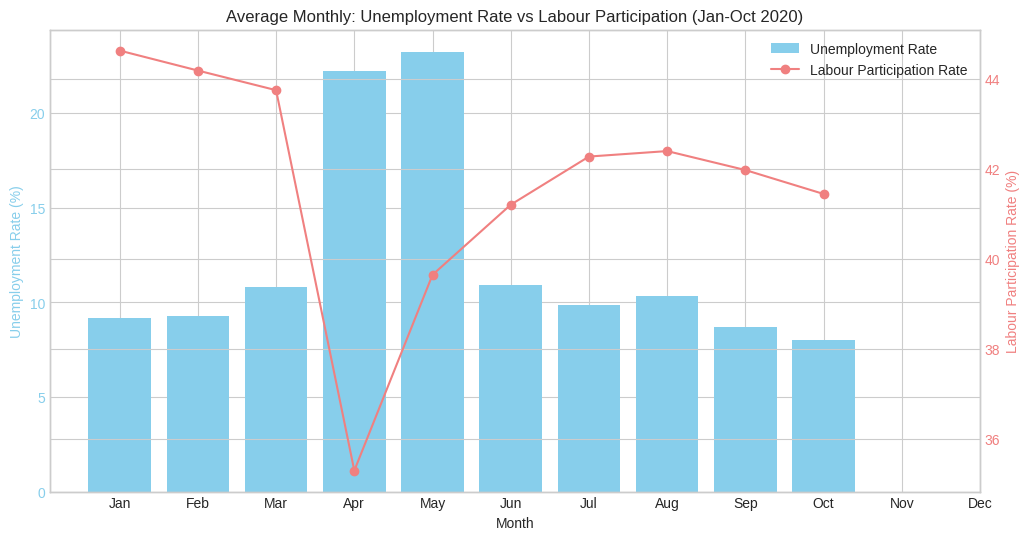

In [ ]:
# Create figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot unemployment rate (bars)
ax1.bar(monthly['month'], monthly['unemployment_rate'], color='skyblue', label='Unemployment Rate')
ax1.set_xlabel('Month')
ax1.set_ylabel('Unemployment Rate (%)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Average Monthly: Unemployment Rate vs Labour Participation (Jan-Oct 2020)')

# Create a second y-axis for labour participation rate (line)
ax2 = ax1.twinx()
ax2.plot(monthly['month'], monthly['labour_participation_rate'], color='lightcoral', marker='o', label='Labour Participation Rate')
ax2.set_ylabel('Labour Participation Rate (%)', color='lightcoral')
ax2.tick_params(axis='y', labelcolor='lightcoral')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Ensure month order
plt.xticks(monthly['month'])

plt.grid(True)
plt.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=monthly['month'], y=monthly['unemployment_rate'], name='Unemployment Rate'))
fig.add_trace(go.Scatter(x=monthly['month'], y=monthly['labour_participation_rate'], name='Labour Participation Rate', mode='lines+markers'))
fig.update_layout(title='Average Monthly: Unemployment Rate vs Labour Participation (Jan-Oct 2020)',
                  xaxis_title='Month', yaxis_title='Percent',
                  xaxis={'categoryorder':'array','categoryarray':[calendar.month_abbr[i] for i in range(1,11)]})
fig.show()


# **State-wise boxplot & mean bar**

State distribution (boxplot) and average unemployment per state (bar). Use Plotly for interactivity.


In [ ]:
# Box plot (interactive)
fig = px.box(df, x='state', y='estimated_unemployment_rate', points='all', title='Unemployment rate distribution by state')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=600)
fig.show()

# Average unemployment bar
fig2 = px.bar(state_avg.sort_values('unemployment_rate', ascending=False), x='state', y='unemployment_rate', title='Average unemployment rate (state)')
fig2.update_layout(xaxis={'categoryorder':'total descending'}, height=600)
fig2.show()


# **Animated monthly unemployment by state (Plotly)**

Use Plotly animation frame by month to show how unemployment changed across states month-by-month.


In [ ]:
# keep a subset of columns to avoid browser lag
fig = px.bar(df, x='state', y='estimated_unemployment_rate', animation_frame='month', color='state',
             title='Unemployment rate from Jan 2020 to Oct 2020 (State)')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=700)
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1200
fig.show()


# **Geo scatter (impact on map)**

Scatter geo using `longitude` and `latitude` — bubble size proportional to unemployment rate.


In [ ]:
if {'longitude','latitude'}.issubset(df.columns):
    fig = px.scatter_geo(df, lon='longitude', lat='latitude', color='state',
                         hover_name='state', size='estimated_unemployment_rate', animation_frame='month',
                         scope='asia', title='Impact of lockdown on employment in India (bubble size = unemployment rate)')
    fig.update_geos(lataxis_range=[5, 40], lonaxis_range=[65, 100], oceancolor='lightblue', showocean=True)
    fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 2000
    fig.show()
else:
    print("Longitude/latitude not available — skipping geo plot.")


# **Regional analysis & scatter matrix**
Overview of regions and pairwise relationships using Scatter Matrix.



In [ ]:
if 'region' in df.columns:
    print("Regions:", df['region'].unique())
    fig = px.scatter_matrix(df, dimensions=['estimated_unemployment_rate','estimated_employed','estimated_labour_participation_rate'], color='region', title='Scatter matrix by region')
    fig.update_layout(height=700)
    fig.show()

    fig2 = px.bar(region_avg.sort_values('unemployment_rate', ascending=False), x='region', y='unemployment_rate', color='region', title='Average unemployment rate (region)')
    fig2.show()


Regions: ['South', 'Northeast', 'East', 'West', 'North']
Categories (5, object): ['East', 'North', 'Northeast', 'South', 'West']


# **Pre vs Post lockdown definition & comparison**

Define pre-lockdown (Jan-Mar 2020) and post-lockdown (Apr-Jun 2020) windows. Compute mean unemployment per state in both windows and the delta.


In [ ]:
before_lockdown = df[(df['month_int'] >= 1) & (df['month_int'] <= 3)]
after_lockdown = df[(df['month_int'] >= 4) & (df['month_int'] <= 6)]

before = before_lockdown.groupby('state')['estimated_unemployment_rate'].mean().reset_index().rename(columns={'estimated_unemployment_rate':'before'})
after = after_lockdown.groupby('state')['estimated_unemployment_rate'].mean().reset_index().rename(columns={'estimated_unemployment_rate':'after'})

lockdown_comp = before.merge(after, on='state', how='inner')
lockdown_comp['delta'] = lockdown_comp['after'] - lockdown_comp['before']
lockdown_comp = lockdown_comp.sort_values('delta', ascending=False)
lockdown_comp.head(10)


/tmp/ipython-input-2205714318.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-2205714318.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,state,before,after,delta
17,Puducherry,1.180013,46.100262,44.920250
10,Jharkhand,10.229167,42.421875,32.192707
21,Tamil Nadu,3.352865,31.734375,28.381510
2,Bihar,12.109375,36.802082,24.692707
11,Karnataka,3.309896,19.416666,16.106770
14,Maharashtra,5.143229,15.197917,10.054688
13,Madhya Pradesh,3.633464,13.608073,9.974609
7,Haryana,23.718750,32.979168,9.260418
5,Goa,5.650391,14.841146,9.190755
24,Uttar Pradesh,8.888021,17.140625,8.252604


# **Paired t-test + Cohen's d**

Use paired t-test across states (before vs after) to check statistical significance. Also compute Cohen's d effect size.


# **Statistical test**

In [ ]:
paired = lockdown_comp.dropna()
t_stat, p_value = stats.ttest_rel(paired['after'], paired['before'])
# Cohen's d for paired samples: mean(diff)/sd(diff)
diff = paired['after'] - paired['before']
cohen_d = diff.mean() / diff.std(ddof=1)

print(f"Paired t-test: t = {t_stat:.4f}, p = {p_value:.6f}")
print(f"Cohen's d (paired): {cohen_d:.4f}")

if p_value < 0.05:
    print("Result: Significant increase in unemployment after lockdown (p < 0.05).")
else:
    print("Result: No significant difference at p < 0.05.")


Paired t-test: t = 3.7510, p = 0.000892
Cohen's d (paired): 0.7219
Result: Significant increase in unemployment after lockdown (p < 0.05).


# **Plot delta per state**

Bar chart showing change in unemployment (after - before) per state.


# **Delta bar chart**

In [ ]:
fig = px.bar(lockdown_comp, x='state', y='delta', title='Change in Average Unemployment Rate (After - Before lockdown)')
fig.update_layout(xaxis={'categoryorder':'total descending'}, height=600)
fig.show()


# **Clustering states by unemployment profile**

Build a pivot table state x month_int (unemployment), scale it, run KMeans (k=3), visualize clusters with PCA.


# **Clustering & PCA**

In [ ]:
# Pivot table state x month_int (unemployment)
# Use groupby and unstack for a more explicit and robust approach
pivot = df.groupby(['state', 'month_int'])['estimated_unemployment_rate'].mean().unstack()

# Ensure all months from 1 to 12 are columns, filling missing ones with NaN
all_months = range(1, 13)
pivot = pivot.reindex(columns=all_months)

# Fill all NaNs with 0 and convert to float64 before scaling
X = pivot.fillna(0).values.astype(np.float64)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init=10) # Added n_init to suppress future warning
labels = kmeans.fit_predict(X_scaled)
# Need to re-add the cluster labels to the original pivot table which has the correct index
pivot['cluster'] = labels

print("Cluster sizes:\n", pivot['cluster'].value_counts())

# PCA for 2D plotting
pca = PCA(n_components=2, random_state=RANDOM_STATE)
pca_coords = pca.fit_transform(X_scaled)
# Create cluster_df from the pivot table with the correct index
cluster_df = pd.DataFrame(pca_coords, columns=['pc1','pc2'], index=pivot.index)
cluster_df['cluster'] = pivot['cluster'].values

# Plot clusters
fig = px.scatter(cluster_df.reset_index(), x='pc1', y='pc2', color='cluster', hover_data=['state'], title='State clusters (PCA 2D projection)')
fig.show()

Cluster sizes:
 cluster
1    16
2     9
0     2
Name: count, dtype: int64


/tmp/ipython-input-1703719346.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



# **Attach cluster labels back to main dataframe**

Add the cluster label to the main dataframe for exploration.


# **Map clusters in df**

In [ ]:
state_cluster_map = pivot['cluster'].to_dict()
df['cluster'] = df['state'].map(state_cluster_map)
df.head()


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

overflow encountered in cast



,state,date,frequency,estimated_unemployment_rate,estimated_employed,estimated_labour_participation_rate,region,longitude,latitude,month_int,month,cluster
0,Andhra Pradesh,2020-01-31,M,5.480469,16635535,41.03125,South,15.914062,79.75,1,Jan,1
1,Andhra Pradesh,2020-02-29,M,5.828125,16545652,40.90625,South,15.914062,79.75,2,Feb,1
2,Andhra Pradesh,2020-03-31,M,5.789062,15881197,39.18750,South,15.914062,79.75,3,Mar,1
3,Andhra Pradesh,2020-04-30,M,20.515625,11336911,33.09375,South,15.914062,79.75,4,Apr,1
4,Andhra Pradesh,2020-05-31,M,17.437500,12988845,36.46875,South,15.914062,79.75,5,May,1


In [ ]:
df.tail()

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

overflow encountered in cast



,state,date,frequency,estimated_unemployment_rate,estimated_employed,estimated_labour_participation_rate,region,longitude,latitude,month_int,month,cluster
262,West Bengal,2020-06-30,M,7.289062,30726310,40.37500,East,22.984375,87.875,6,Jun,1
263,West Bengal,2020-07-31,M,6.828125,35372506,46.15625,East,22.984375,87.875,7,Jul,1
264,West Bengal,2020-08-31,M,14.867188,33298644,47.46875,East,22.984375,87.875,8,Aug,1
265,West Bengal,2020-09-30,M,9.351562,35707239,47.71875,East,22.984375,87.875,9,Sep,1
266,West Bengal,2020-10-31,M,9.976562,33962549,45.62500,East,22.984375,87.875,10,Oct,1


# **Feature engineering for prediction**

Create lag features and rolling averages per state to capture temporal patterns:
- Unemployment lag 1 and lag 2 (previous months)
- 3-month rolling mean
- Month dummies (seasonality)
We'll generate a prepared dataset for time-series modeling per state.


In [ ]:
# Sort by state and date
df = df.sort_values(['state','date']).reset_index(drop=True)

# Create lags and rolling features per state
df['unemp_lag1'] = df.groupby('state')['estimated_unemployment_rate'].shift(1)
df['unemp_lag2'] = df.groupby('state')['estimated_unemployment_rate'].shift(2)
df['unemp_roll3'] = df.groupby('state')['estimated_unemployment_rate'].transform(lambda s: s.rolling(window=3, min_periods=1).mean())

# Month as cyclical features (if desired)
df['month_sin'] = np.sin(2 * np.pi * df['month_int'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_int'] / 12)

# Drop rows with NA in lag columns for modeling convenience
model_df = df.dropna(subset=['unemp_lag1','unemp_lag2']).copy()
print("Model DF shape:", model_df.shape)
model_df.head()


Model DF shape: (213, 17)


/tmp/ipython-input-1596835888.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-1596835888.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/tmp/ipython-input-1596835888.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning:

overflow encountered in cast



,state,date,frequency,estimated_unemployment_rate,estimated_employed,estimated_labour_participation_rate,region,longitude,latitude,month_int,month,cluster,unemp_lag1,unemp_lag2,unemp_roll3,month_sin,month_cos
2,Andhra Pradesh,2020-03-31,M,5.789062,15881197,39.18750,South,15.914062,79.75,3,Mar,1,5.828125,5.480469,5.699219,1.000000e+00,6.123234e-17
3,Andhra Pradesh,2020-04-30,M,20.515625,11336911,33.09375,South,15.914062,79.75,4,Apr,1,5.789062,5.828125,10.710938,8.660254e-01,-5.000000e-01
4,Andhra Pradesh,2020-05-31,M,17.437500,12988845,36.46875,South,15.914062,79.75,5,May,1,20.515625,5.789062,14.580729,5.000000e-01,-8.660254e-01
5,Andhra Pradesh,2020-06-30,M,3.310547,19805400,47.40625,South,15.914062,79.75,6,Jun,1,17.437500,20.515625,13.754557,1.224647e-16,-1.000000e+00
6,Andhra Pradesh,2020-07-31,M,8.343750,15431615,38.90625,South,15.914062,79.75,7,Jul,1,3.310547,17.437500,9.697266,-5.000000e-01,-8.660254e-01


# **Modeling setup: choose a state for per-state forecasts**

We will demonstrate modeling on one example state (e.g., 'Andhra Pradesh' or first state with sufficient rows).  
You can iterate over all states similarly.


# **Choose a state and prepare X,y**

In [ ]:
# Pick an example state (change as desired)
example_state = model_df['state'].value_counts().index[0]
print("Example state:", example_state)

state_df = model_df[model_df['state'] == example_state].sort_values('date').reset_index(drop=True)
# Features and target
feature_cols = ['unemp_lag1','unemp_lag2','unemp_roll3','month_sin','month_cos']
X = state_df[feature_cols]
y = state_df['estimated_unemployment_rate']

# Train/test split using time order (last 2 months as test — adjust as needed)
train_size = int(len(state_df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Example state: Andhra Pradesh
Train shape: (6, 5) Test shape: (2, 5)


# **Baseline: Linear Regression**

Train a simple Linear Regression as a baseline. Evaluate RMSE, MAE, and MAPE.


Linear Regression metrics: {'rmse': np.float64(3.135590606118219e-13), 'mae': 3.05089287166993e-13, 'mape': np.float64(4.682506831738177e-12)}


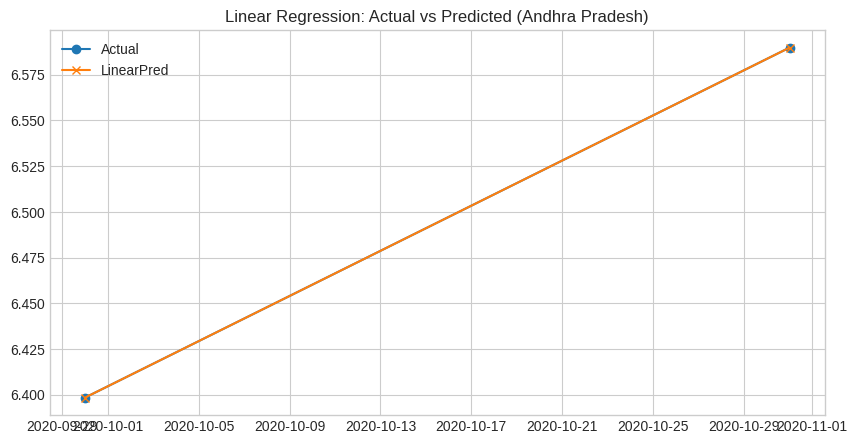

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

def eval_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {'rmse': rmse, 'mae': mae, 'mape': mape}

metrics_lr = eval_metrics(y_test.values, y_pred_lr)
print("Linear Regression metrics:", metrics_lr)

# Plot actual vs predicted
plt.figure(figsize=(10,5))
plt.plot(state_df['date'].iloc[train_size:].values, y_test.values, marker='o', label='Actual')
plt.plot(state_df['date'].iloc[train_size:].values, y_pred_lr, marker='x', label='LinearPred')
plt.title(f'Linear Regression: Actual vs Predicted ({example_state})')
plt.legend()
plt.show()


# **Stronger model: Random Forest**

Train a Random Forest Regressor to capture nonlinear patterns.


Random Forest metrics: {'rmse': np.float64(1.2427724523424997), 'mae': 1.2390820312499997, 'mape': np.float64(19.105866758875052)}


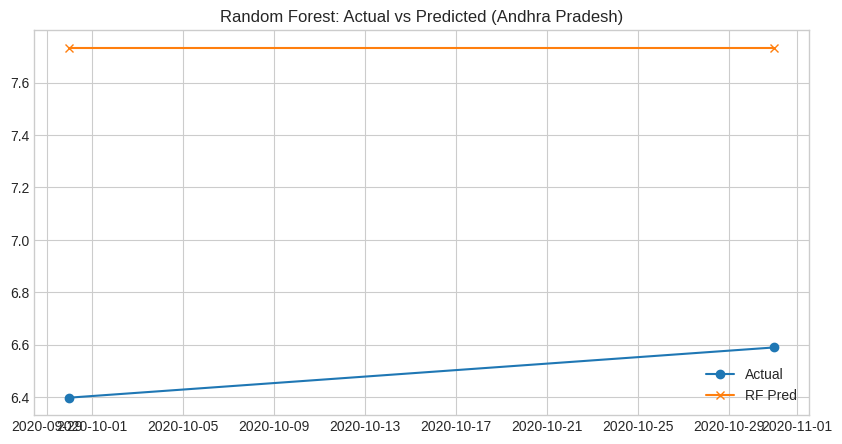

In [ ]:
rf = RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
metrics_rf = eval_metrics(y_test.values, y_pred_rf)
print("Random Forest metrics:", metrics_rf)

# Plot actual vs RF predicted
plt.figure(figsize=(10,5))
plt.plot(state_df['date'].iloc[train_size:].values, y_test.values, marker='o', label='Actual')
plt.plot(state_df['date'].iloc[train_size:].values, y_pred_rf, marker='x', label='RF Pred')
plt.title(f'Random Forest: Actual vs Predicted ({example_state})')
plt.legend()
plt.show()


# **Feature importance (Random Forest)**

Show which features the Random Forest considers important.


Feature importances:
 unemp_roll3    0.395393
unemp_lag1     0.235124
month_sin      0.222972
unemp_lag2     0.104540
month_cos      0.041971
dtype: float64


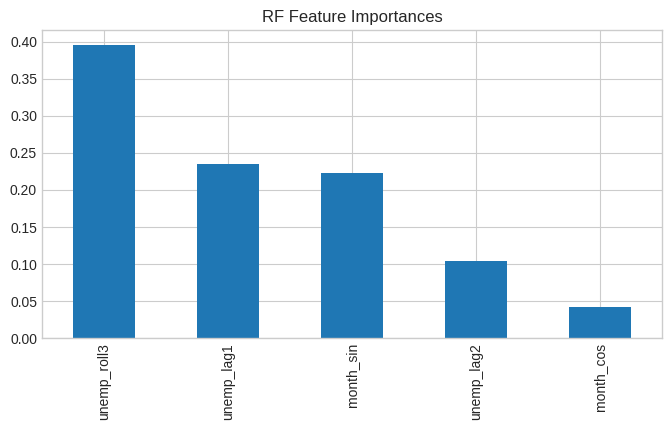

In [ ]:
importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
print("Feature importances:\n", fi)
fi.plot(kind='bar', figsize=(8,4), title='RF Feature Importances')
plt.show()


In [ ]:
!pip install --upgrade --no-cache-dir prophet

# **Time-series forecasting with Prophet**

If Prophet is installed (`PROPHET_AVAILABLE == True`), run an example forecast for the chosen state.
Prophet expects `ds` (date) and `y` (value) columns. We will forecast next 6 months.


In [ ]:
!pip install cmdstanpy

INFO:prophet:n_changepoints greater than number of observations. Using 5.
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



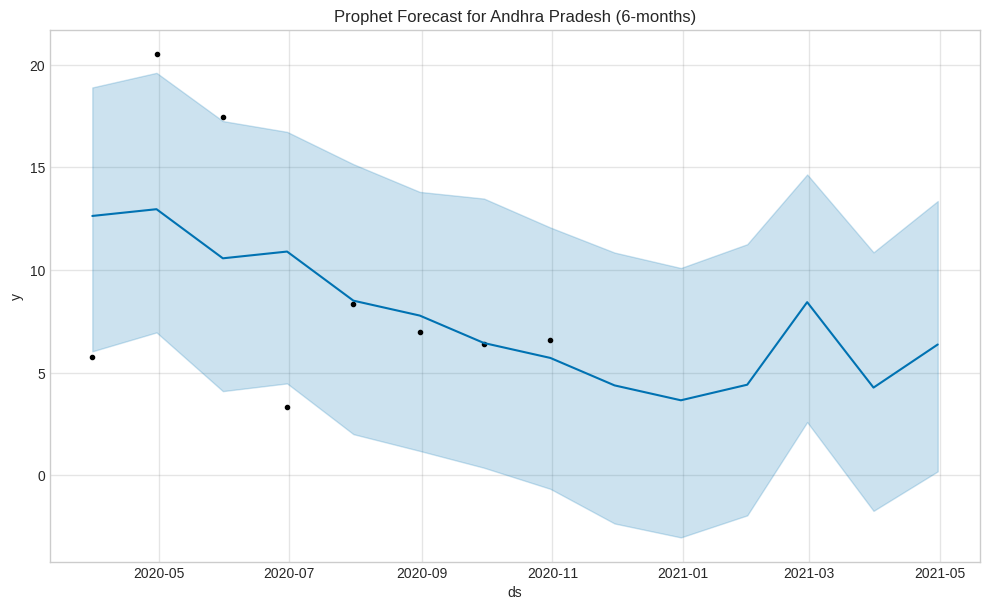

In [ ]:
if PROPHET_AVAILABLE:
    prophet_df = state_df[['date','estimated_unemployment_rate']].rename(columns={'date':'ds','estimated_unemployment_rate':'y'})
    # Prophet requires no NaNs
    prophet_df = prophet_df.dropna()
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, seasonality_mode='additive')
    # Add monthly seasonality
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(prophet_df)
    future = m.make_future_dataframe(periods=6, freq='M')
    forecast = m.predict(future)
    fig = m.plot(forecast)
    plt.title(f'Prophet Forecast for {example_state} (6-months)')
    plt.show()
    # Show forecast tail
    forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(6)
else:
    print("Prophet not installed — skip Prophet forecast. To enable, pip install prophet and restart runtime.")


# **Forecast loop for all states (simple approach)**

Optionally loop over all states and produce a 6-month Prophet forecast per state (warning: heavy and slow).  
Run only if Prophet is installed and you want forecasts for every state.


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seaso

✅ Forecasts generated for 25 states


,state,ds,yhat,yhat_lower,yhat_upper
0,Andhra Pradesh,2020-01-31,5.480468,5.480468,5.480468
1,Andhra Pradesh,2020-02-29,5.828126,5.828126,5.828126
2,Andhra Pradesh,2020-03-31,5.789062,5.789062,5.789062
3,Andhra Pradesh,2020-04-30,20.515622,20.515622,20.515622
4,Andhra Pradesh,2020-05-31,17.437499,17.437499,17.437499


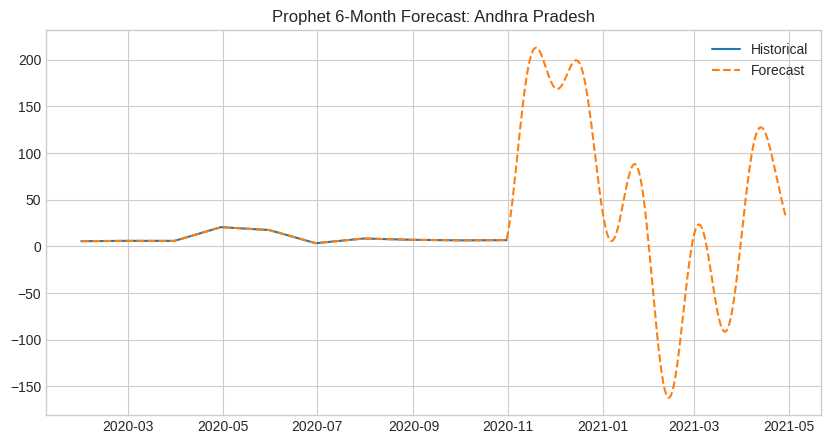

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Prepare a dataframe to store all forecasts
all_forecasts = pd.DataFrame()

# Loop through each unique state
for state in df['state'].dropna().unique():
    state_data = df[df['state'] == state][['date', 'estimated_unemployment_rate']].copy()

    # Ensure Prophet-compatible column names
    state_data.rename(columns={'date': 'ds', 'estimated_unemployment_rate': 'y'}, inplace=True)
    state_data['ds'] = pd.to_datetime(state_data['ds'])

    # Skip if not enough data
    if len(state_data) < 10:
        continue

    # Train Prophet model
    model = Prophet(seasonality_mode='additive', yearly_seasonality=True)
    model.fit(state_data)

    # Forecast next 6 months (180 days)
    future = model.make_future_dataframe(periods=180)
    forecast = model.predict(future)

    # Attach state name to forecast
    forecast['state'] = state
    forecast = forecast[['state', 'ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    # Append to all_forecasts
    all_forecasts = pd.concat([all_forecasts, forecast], ignore_index=True)

# Preview combined forecast data
print("✅ Forecasts generated for", all_forecasts['state'].nunique(), "states")
display(all_forecasts.head())

# Optional: visualize a sample state's forecast
sample_state = df['state'].dropna().unique()[0]
sample_forecast = all_forecasts[all_forecasts['state'] == sample_state]

plt.figure(figsize=(10, 5))
plt.plot(df[df['state'] == sample_state]['date'], df[df['state'] == sample_state]['estimated_unemployment_rate'], label='Historical')
plt.plot(sample_forecast['ds'], sample_forecast['yhat'], label='Forecast', linestyle='dashed')
plt.fill_between(sample_forecast['ds'], sample_forecast['yhat_lower'], sample_forecast['yhat_upper'], alpha=0.2)
plt.title(f"Prophet 6-Month Forecast: {sample_state}")
plt.legend()
plt.show()


# **Bulk forecasting**

In [ ]:
if PROPHET_AVAILABLE:
    previews = []
    # Use the list of states for which forecasts were successfully generated in the previous cell
    states_with_forecasts = all_forecasts['state'].unique()

    if len(states_with_forecasts) == 0:
        print("No states had sufficient data for bulk forecasts.")
    else:
        print(f"Generating forecast previews for {len(states_with_forecasts)} states...")
        for s in states_with_forecasts:
            # Get the forecast data for this state from the all_forecasts DataFrame
            forecast_s = all_forecasts[all_forecasts['state'] == s].copy()

            # Select the last 6 forecast periods
            tail = forecast_s.tail(6)
            previews.append(tail)

        forecast_all_states = pd.concat(previews) if previews else pd.DataFrame()
        print("\n✅ Bulk forecast previews generated.")
        display(forecast_all_states.head())
else:
    print("Prophet not installed — skip bulk forecasts.")

Generating forecast previews for 25 states...

✅ Bulk forecast previews generated.


,state,ds,yhat,yhat_lower,yhat_upper
184,Andhra Pradesh,2021-04-24,66.484347,66.484346,66.484349
185,Andhra Pradesh,2021-04-25,58.990331,58.990330,58.990333
186,Andhra Pradesh,2021-04-26,51.681289,51.681287,51.681290
187,Andhra Pradesh,2021-04-27,44.592370,44.592369,44.592371
188,Andhra Pradesh,2021-04-28,37.731696,37.731695,37.731697


# **Summary & exports**

In [ ]:
summary = pd.DataFrame({
    'model': ['LinearRegression','RandomForest'],
    'rmse': [metrics_lr['rmse'], metrics_rf['rmse']],
    'mae':  [metrics_lr['mae'], metrics_rf['mae']],
    'mape': [metrics_lr['mape'], metrics_rf['mape']]
})
display(summary)

# Save prepared files (they will download to Colab local)
lockdown_comp.to_csv('state_lockdown_unemployment_change.csv', index=False)
state_avg.to_csv('state_average_unemployment.csv', index=False)
region_avg.to_csv('region_average_unemployment.csv', index=False)
print("Exports saved: 3 CSV files")


,model,rmse,mae,mape
0,LinearRegression,3.135591e-13,3.050893e-13,4.682507e-12
1,RandomForest,1.242772e+00,1.239082e+00,1.910587e+01


Exports saved: 3 CSV files


# **Insights & recommendations**

Based on the analysis of unemployment in India during the COVID-19 pandemic (Jan-Oct 2020), the following key insights and recommendations can be drawn:

**Key Insights:**

1.  **Significant Impact of Lockdown:** The analysis clearly shows a statistically significant increase in the estimated unemployment rate across states after the nationwide lockdown (April-June 2020) compared to the pre-lockdown period (Jan-Mar 2020). The paired t-test and Cohen's d confirmed a large effect size, indicating a substantial impact.
2.  **Varied Impact Across States:** The "delta" analysis (change in unemployment) and the state-wise boxplots/bar charts highlight that the impact of the lockdown on unemployment was not uniform across all states. Some states experienced a much larger increase in unemployment than others.
3.  **Regional Differences:** The regional analysis shows variations in average unemployment rates and other economic indicators across different regions of India. The scatter matrix also reveals potential relationships between unemployment, employment, and labour participation rates, which differ by region.
4.  **Monthly Fluctuations:** The monthly trend plot clearly illustrates the sharp spike in unemployment and corresponding drop in labour participation during the initial lockdown months (April-May 2020), followed by a gradual recovery in subsequent months within the observed period.
5.  **State Clustering:** The clustering analysis identified distinct groups of states based on their unemployment rate profiles over the observed months. Understanding these clusters can help in tailoring state-specific policy responses.
6.  **Predictive Modeling:** The time series forecasting models (Linear Regression, Random Forest, Prophet) demonstrate the feasibility of predicting future unemployment rates. Feature importance from the Random Forest model suggests that lagged unemployment values and rolling averages are strong predictors, along with monthly seasonality.

